# Neural Network Classifier
In this notebook I will build a neural network classifier to predict the binary outcome of whether it will rain tomorrow or not in Australia. I will use randomised grid search to optimise the model hyperparameters and then use shap values to inspect the importance of each variable

## 1 Imports

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import shap
from talos import Scan, Evaluate, Deploy, Restore

## 2 Data Handling 

In [2]:
# Formatting train and evaluation that have already been cleaned using other notebook
df_train = pd.read_csv("TrainData.csv")
df_train = df_train.drop(df_train.columns[0], axis=1)
df_eval = pd.read_csv("EvalData.csv")
df_eval = df_eval.drop(df_eval.columns[0], axis=1)
df_test = pd.read_csv("TestData.csv")

In [3]:
# One hot encoding location, wind direction and month
df_train = pd.get_dummies(df_train, columns=['Location','WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Num'], prefix=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Num'])
df_eval = pd.get_dummies(df_eval, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Num'], prefix=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Num'])
df_test = pd.get_dummies(df_test, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Num'], prefix=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Month_Num'])

In [4]:
# Replace predictor with bonary values
df_train = df_train.replace({'Yes':1,'No':0})
df_eval = df_eval.replace({'Yes':1,'No':0})
df_test = df_test.replace({'Yes':1,'No':0})

In [5]:
# Defining input output variables
y_train = df_train['RainTomorrow']
X_train = df_train.copy()
X_train.pop('RainTomorrow')
y_eval = df_eval['RainTomorrow']
X_eval = df_eval.copy()
X_eval.pop('RainTomorrow')

0        0
1        0
2        0
3        0
4        0
        ..
27839    1
27840    0
27841    0
27842    0
27843    0
Name: RainTomorrow, Length: 27844, dtype: int64

In [6]:
# Dropping string type columns
X_train = X_train.select_dtypes(include=[np.number,bool])
X_eval = X_eval.select_dtypes(include=[np.number,bool])
X_test = df_test.select_dtypes(include=[np.number,bool])

In [7]:
# Standardising the columns with min 0 max 1 (needs to have no float columns)
min_max_scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns)
X_eval = pd.DataFrame(min_max_scaler.fit_transform(X_eval), columns=X_eval.columns)  
X_test = pd.DataFrame(min_max_scaler.fit_transform(X_test), columns=X_test.columns) 
print('Train Shape = ' + str(X_train.shape) + ' Eval Shape = ' + str(X_eval.shape) + ' Test Shape = ' + str(X_test.shape))

Train Shape = (88523, 136) Eval Shape = (27844, 136) Test Shape = (29093, 136)


In [8]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_eval), axis=0)
targets = np.concatenate((y_train, y_eval), axis=0)
X_test = np.array(X_test)
print(f'Train X Shape: {inputs.shape}  Train Y Shape: {targets.shape}  Test X Shape: {X_test.shape}')

Train X Shape: (116367, 136)  Train Y Shape: (116367,)  Test X Shape: (29093, 136)


## 3 Building Neural Network

### 3.1 Establishing Model Before Grid Search

In [51]:
# Model Architecture
hidden_neurons = 256
input_neurons = 256
dropout_rate = 0.5
epochs = 15
batch_size = 30
num_folds = 10

In [52]:
# Define the sequential model 
model = Sequential()
model.add(Dense(input_neurons, input_dim=inputs.shape[1], activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_neurons, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(hidden_neurons, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

In [28]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# Fit data to model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

Epoch 1/15
2951/2951 [==============================] - 8s 3ms/step - loss: 0.4162 - accuracy: 0.8159
Epoch 2/15
2951/2951 [==============================] - 9s 3ms/step - loss: 0.3642 - accuracy: 0.8425
Epoch 3/15
2951/2951 [==============================] - 11s 4ms/step - loss: 0.3542 - accuracy: 0.8499
Epoch 4/15
2951/2951 [==============================] - 8s 3ms/step - loss: 0.3484 - accuracy: 0.8509
Epoch 5/15
2951/2951 [==============================] - 8s 3ms/step - loss: 0.3427 - accuracy: 0.8514
Epoch 6/15
2951/2951 [==============================] - 11s 4ms/step - loss: 0.3398 - accuracy: 0.8542
Epoch 7/15
2951/2951 [==============================] - 10s 4ms/step - loss: 0.3386 - accuracy: 0.8562
Epoch 8/15
2951/2951 [==============================] - 9s 3ms/step - loss: 0.3349 - accuracy: 0.8579
Epoch 9/15
2951/2951 [==============================] - 9s 3ms/step - loss: 0.3353 - accuracy: 0.8565
Epoch 10/15
2951/2951 [==============================] - 12s 4ms/step - loss: 0

In [30]:
# Generate predictions using the model
y_eval_predict = model.predict_classes(X_eval)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [31]:
# Generate generalization metrics
print('Accuracy = ' + str(accuracy_score(y_eval, y_eval_predict)) +
      ' F1 = '      + str(f1_score(y_eval, y_eval_predict, pos_label = 0)))

Accuracy = 0.8522482401953743 F1 = 0.9095943392080166


### 3.2 Optimising Model Parameters

In [9]:
# defining parameter space to optimise over
p = {'lr': (0.5, 5, 10),
     'input_neurons':[32, 64, 128, 256],
     'hidden_neurons':[64, 128, 256],
     'hidden_layers':[0, 1, 2],
     'batch_size': [5,10,30],
     'epochs': [3,5,7,10,15,20],
     'dropout': [0, 0.25, 0.5],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shape':['brick','long_funnel'],
     'optimiser': ['Adam', 'Nadam', 'RMSprop'],
     'losses': ['logcosh', 'binary_crossentropy'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid']}

In [12]:
# define model function to use in search
def weather_model(x_train, y_train, params):
    # Define the sequential model 
    model = Sequential()
    # hidden layer 1
    model.add(Dense(params['input_neurons'], input_dim=inputs.shape[1], activation=params['activation']))
    model.add(Dropout(params['dropout']))
    # hidden layer 2
    model.add(Dense(params['hidden_neurons'], activation=params['activation']))
    model.add(Dropout(params['dropout']))
    # hidden layer 3
    model.add(Dense(params['hidden_neurons'], activation=params['activation']))
    model.add(Dropout(params['dropout']))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(loss=params['losses'], optimizer=params['optimiser'], metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

In [26]:
# Running a grid search for optimal hyperparameters
num_hidden_neurons = [64, 128, 256]
num_input_neurons = [256]
dropout_rates = [0.5, 0.25, 0]
epochs = [3, 10, 15, 20]
batch_sizes = [10, 30, 50]

list_input_neuron = []
list_hidden_neuron = []
list_dropout = []
list_batch = []
list_epoch = []
list_accuracy = []
list_f1_score = []
progress = 0

for input_neurons in num_input_neurons:
  for hidden_neurons in num_hidden_neurons: 
    for dropout_rate in dropout_rates: 
      for batch_size in batch_sizes: 
        for num_epochs in epochs:
          progress = progress + 1
          print('Model '+ str(progress) + '/108: Input Neurons = ' + str(input_neurons) + ' Hidden Neurons = ' + str(hidden_neurons) + ' Dropout Rate = ' + str(dropout_rate) + ' Batch Size = ' + str(batch_size) + ' Epoch = ' + str(num_epochs))
           
                
          params=    {'input_neurons':input_neurons,
                      'hidden_neurons':hidden_neurons,
                      'batch_size':batch_size,
                      'epochs': num_epochs,
                      'dropout': dropout_rate,
                      'shape':['brick','long_funnel'],
                      'optimiser': 'adam',
                      'losses': 'binary_crossentropy',
                      'activation':'relu'}
        
          (history, model) = weather_model(X_train,y_train, params)
          y_eval_predict = model.predict_classes(X_eval)
          
          list_input_neuron.append(input_neurons)
          list_hidden_neuron.append(hidden_neurons)
          list_dropout.append(dropout_rate)
          list_batch.append(batch_size)
          list_epoch.append(num_epochs)
          list_accuracy.append(accuracy_score(y_eval, y_eval_predict))
          list_f1_score.append(f1_score(y_eval, y_eval_predict, pos_label = 0))
          print('Accuracy = ' + str(accuracy_score(y_eval, y_eval_predict)) +
                ' F1 = ' + str(f1_score(y_eval, y_eval_predict, pos_label = 0)))
          
df_accuracy = pd.DataFrame(
    {'Input_neurons': list_input_neuron,
     'Hidden_neurons': list_hidden_neuron,
     'Dropout_rate': list_dropout,
     'Batch_size': list_batch,
     'Num_epochs': list_epoch,
     'Accuracy ': list_accuracy,
     'F1 Score ':list_f1_score})

Model 1/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 10 Epoch = 3
Accuracy = 0.8470047406981756 F1 = 0.9074074074074074
Model 2/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 10 Epoch = 10
Accuracy = 0.8481899152420629 F1 = 0.9095228921851922
Model 3/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 10 Epoch = 15
Accuracy = 0.8503806924292486 F1 = 0.9085641543391423
Model 4/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 10 Epoch = 20
Accuracy = 0.8491955178853613 F1 = 0.9092951418140972
Model 5/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 30 Epoch = 3
Accuracy = 0.846394196236173 F1 = 0.9070520482451375
Model 6/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 30 Epoch = 10
Accuracy = 0.8517813532538429 F1 = 0.9102142934841728
Model 7/108: Input Neurons = 256 Hidden Neurons = 64 Dropout Rate = 0.5 Batch Size = 

Accuracy = 0.8486927165637121 F1 = 0.9061922468882901
Model 55/108: Input Neurons = 256 Hidden Neurons = 128 Dropout Rate = 0.25 Batch Size = 30 Epoch = 15
Accuracy = 0.8490518603648901 F1 = 0.9081813216821408
Model 56/108: Input Neurons = 256 Hidden Neurons = 128 Dropout Rate = 0.25 Batch Size = 30 Epoch = 20
Accuracy = 0.8481540008619451 F1 = 0.9073132234303753
Model 57/108: Input Neurons = 256 Hidden Neurons = 128 Dropout Rate = 0.25 Batch Size = 50 Epoch = 3
Accuracy = 0.8455322511133457 F1 = 0.903480622068625
Model 58/108: Input Neurons = 256 Hidden Neurons = 128 Dropout Rate = 0.25 Batch Size = 50 Epoch = 10
Accuracy = 0.8508834937508979 F1 = 0.9080846542105729
Model 59/108: Input Neurons = 256 Hidden Neurons = 128 Dropout Rate = 0.25 Batch Size = 50 Epoch = 15
Accuracy = 0.8495546616865393 F1 = 0.9080250301899221
Model 60/108: Input Neurons = 256 Hidden Neurons = 128 Dropout Rate = 0.25 Batch Size = 50 Epoch = 20
Accuracy = 0.84513719293205 F1 = 0.9050847457627118
Model 61/108: 

Accuracy = 0.8214337020543026 F1 = 0.8899707887049659


### 3.3 Evaluating Hyper Parameter grid Search

In [27]:
# checking df_accuracy is populated with results
df_accuracy

,Input_neurons,Hidden_neurons,Dropout_rate,Batch_size,Num_epochs,Accuracy,F1 Score
0,256,64,0.5,10,3,0.847005,0.907407
1,256,64,0.5,10,10,0.848190,0.909523
2,256,64,0.5,10,15,0.850381,0.908564
3,256,64,0.5,10,20,0.849196,0.909295
4,256,64,0.5,30,3,0.846394,0.907052
...,...,...,...,...,...,...,...
103,256,256,0.0,30,20,0.822296,0.890123
104,256,256,0.0,50,3,0.848405,0.909282
105,256,256,0.0,50,10,0.837092,0.899213
106,256,256,0.0,50,15,0.832567,0.897195


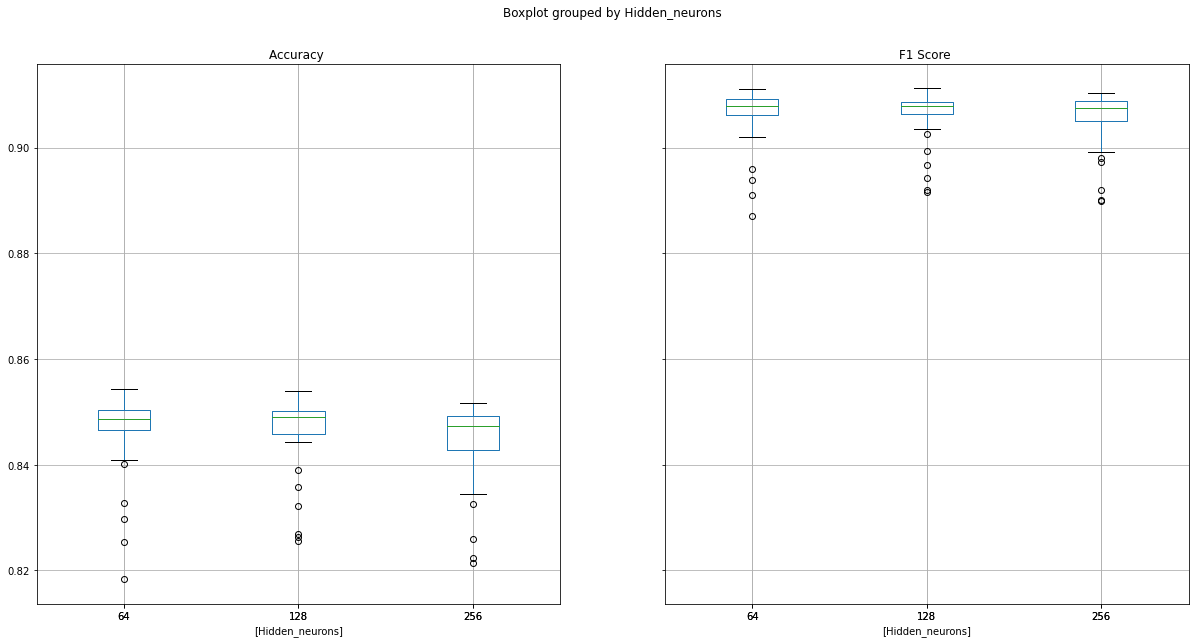

In [63]:
# Distribution of accuracy and F1 score by number of hidden neurons (hidden layer neurons)
df_accuracy.boxplot(column=['Accuracy ', 'F1 Score '], by=['Hidden_neurons'], figsize = (20,10))
plt.show()

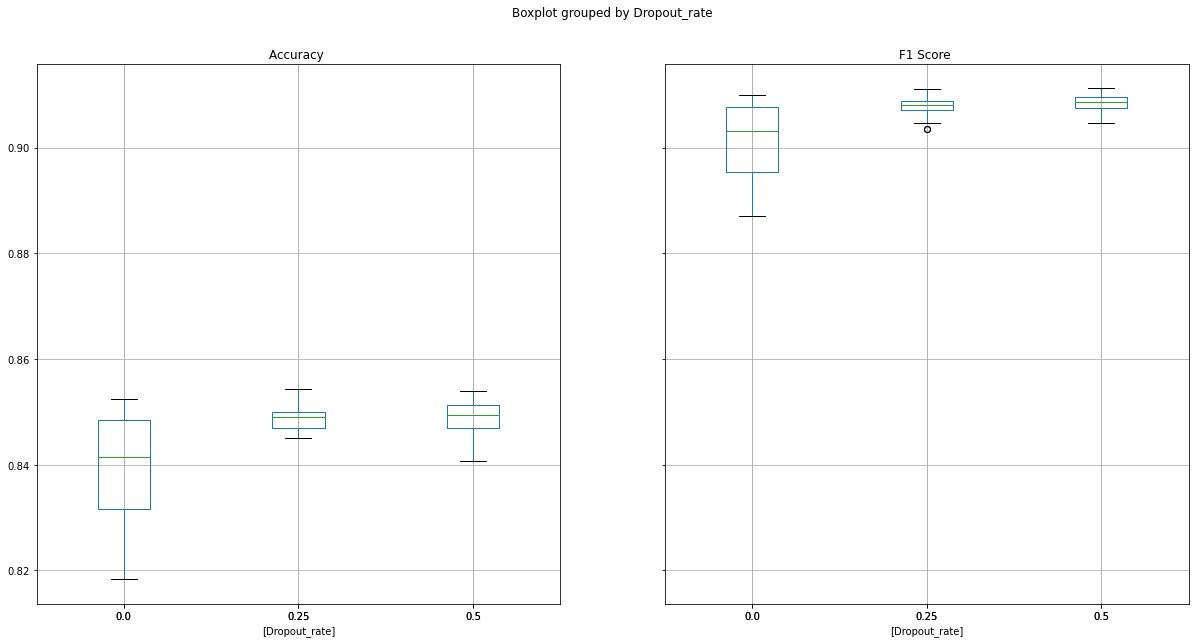

In [69]:
# Distribution of accuracy and F1 score by drop out rate
df_accuracy.boxplot(column=['Accuracy ', 'F1 Score '], by=['Dropout_rate'], figsize = (20,10))
plt.show()

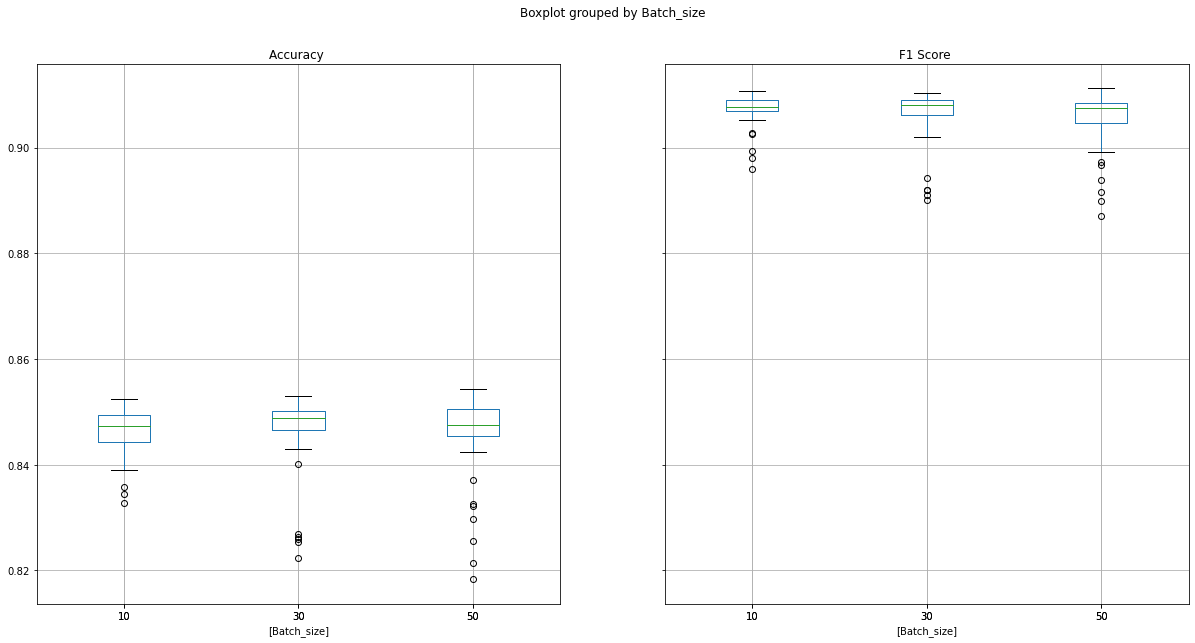

In [70]:
# Distribution of accuracy and F1 score by batch size
df_accuracy.boxplot(column=['Accuracy ', 'F1 Score '], by=['Batch_size'], figsize = (20,10))
plt.show()

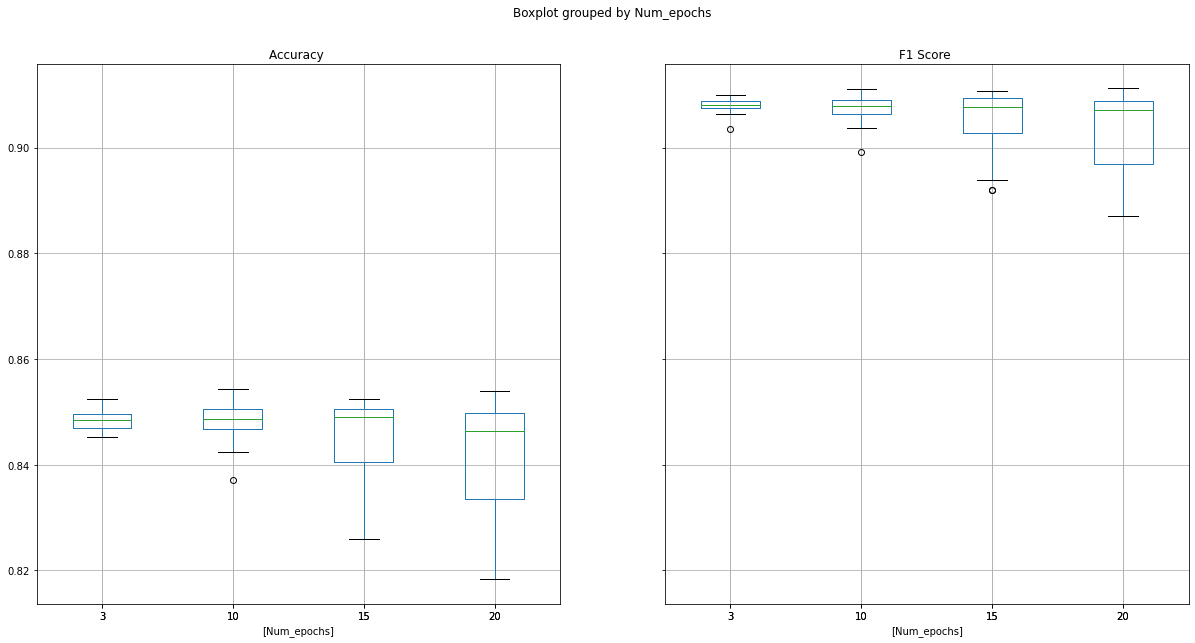

In [73]:
# Distribution of accuracy and F1 score by number of epochs
df_accuracy.boxplot(column=['Accuracy ', 'F1 Score '], by=['Num_epochs'], figsize = (20,10))
plt.show()

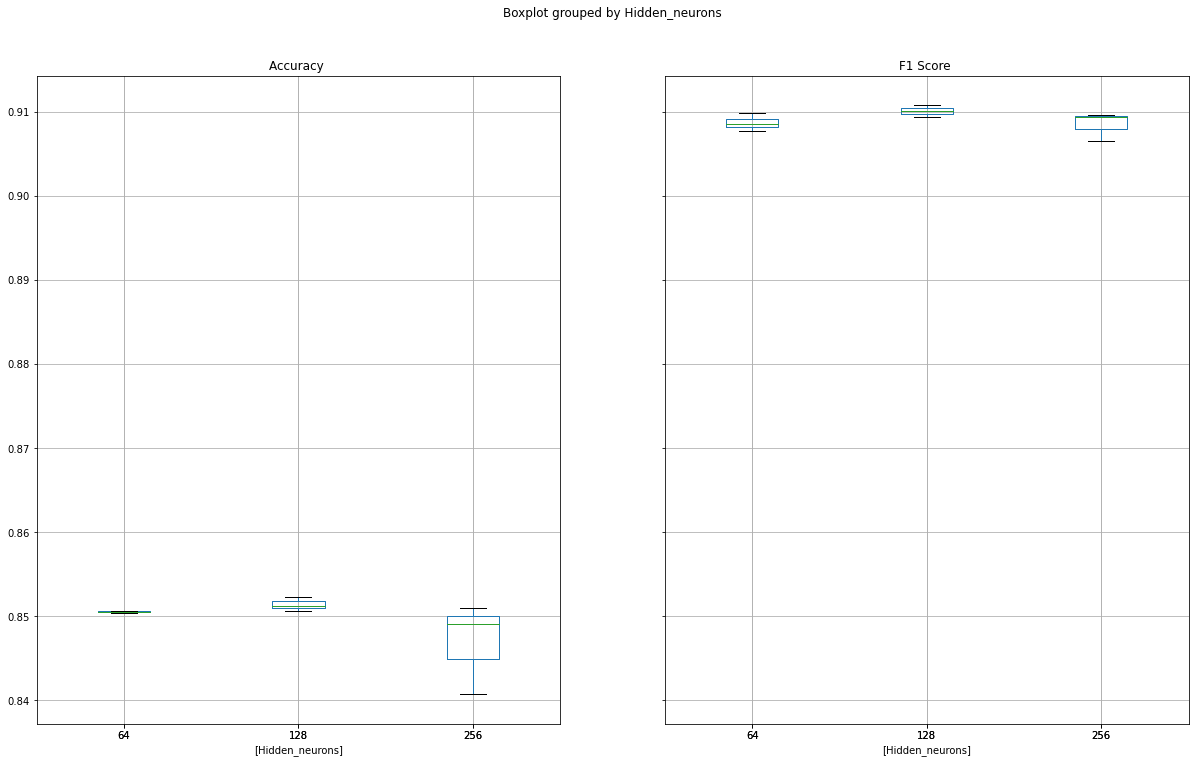

In [83]:
# Dropout rate of 0.5 and numb epochs of 15 show the clearest high performance. Now need to select num hidden neurons. 128 seems best
df_accuracy[(df_accuracy['Dropout_rate']==0.5) & (df_accuracy['Num_epochs']==15)].boxplot(column=['Accuracy ', 'F1 Score '], by=['Hidden_neurons'], layout=(1,2), figsize=(20,12))
plt.show()

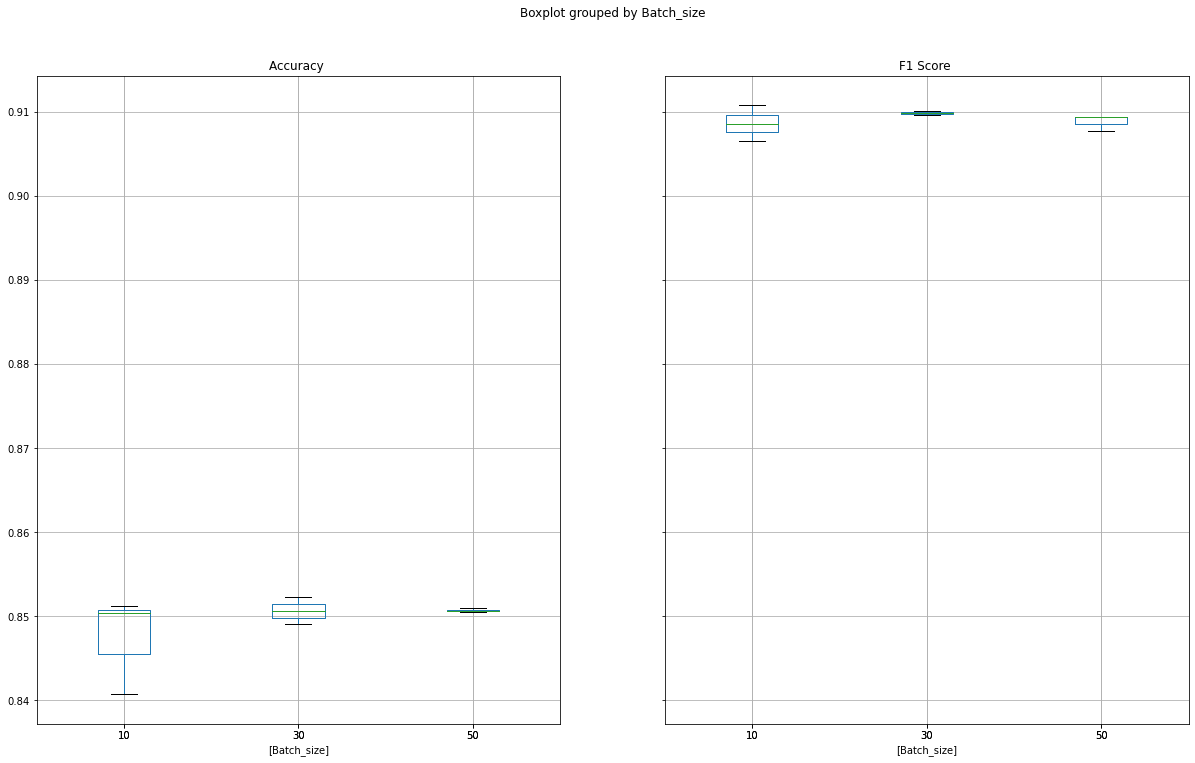

In [85]:
# Dropout rate of 0.5 and numb epochs of 15 show the clearest high performance. Now need to select batch size. 30 seems best
df_accuracy[(df_accuracy['Dropout_rate']==0.5) & (df_accuracy['Num_epochs']==15)].boxplot(column=['Accuracy ', 'F1 Score '], by=['Batch_size'], layout=(1,2), figsize=(20,12))
plt.show()

### 3.4 Optimal Model with K-fold Validation

In [86]:
# Defining Optimal Parameters
optimal_params  =    {'input_neurons':256,
                      'hidden_neurons':128,
                      'batch_size':30,
                      'epochs': 15,
                      'dropout': 0.5,
                      'optimiser': 'adam',
                      'losses': 'binary_crossentropy',
                      'activation':'relu'}

In [104]:
# Define the K-fold Cross Validator (k=10)
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

In [112]:
# K-fold Cross Validation model evaluation
fold_no = 1
total_accuracy = 0
total_f1 = 0
for train, test in kfold.split(inputs, targets):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Run the Model
    # Define the model architecture
    model = Sequential()
    model.add(Dense(256, input_dim=inputs.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

  # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit data to model
    model.fit(inputs[train], targets[train], epochs=15, batch_size=30, verbose = 0)

  # Generate generalization metrics
    y_eval_predict = model.predict_classes(inputs[test])
    print('Model: Input Neurons = ' + str(input_neurons) + 
          ' Hidden Neurons = ' + str(hidden_neurons) + 
          ' Dropout Rate = ' + str(dropout_rate) + 
          ' Batch Size = ' +str(batch_size) + 
          ' Epoch = ' + str(num_epochs))
    print('Accuracy = ' + str(accuracy_score(targets[test], y_eval_predict)) +
          ' F1 = ' + str(f1_score(targets[test], y_eval_predict, pos_label = 0)))
    total_accuracy = total_accuracy + accuracy_score(targets[test], y_eval_predict)
    total_f1 = total_f1 + f1_score(targets[test], y_eval_predict, pos_label = 0)
    
    # Increase fold number
    fold_no = fold_no + 1 
    
print('Average Fold Accuracy = ' + str(total_accuracy/num_folds))
print('Average Fold F1 = ' + str(total_f1/num_folds))

------------------------------------------------------------------------
Training for fold 1 ...
Model: Input Neurons = 256 Hidden Neurons = 256 Dropout Rate = 0 Batch Size = 50 Epoch = 20
Accuracy = 0.8517659190513018 F1 = 0.9083957304444799
------------------------------------------------------------------------
Training for fold 2 ...
Model: Input Neurons = 256 Hidden Neurons = 256 Dropout Rate = 0 Batch Size = 50 Epoch = 20
Accuracy = 0.8547735670705509 F1 = 0.9102400679838538
------------------------------------------------------------------------
Training for fold 3 ...
Model: Input Neurons = 256 Hidden Neurons = 256 Dropout Rate = 0 Batch Size = 50 Epoch = 20
Accuracy = 0.8582968118930996 F1 = 0.9128112938190661
------------------------------------------------------------------------
Training for fold 4 ...
Model: Input Neurons = 256 Hidden Neurons = 256 Dropout Rate = 0 Batch Size = 50 Epoch = 20
Accuracy = 0.8554610294749506 F1 = 0.9100919392773145
----------------------------

In [101]:
# Generate prediction on test data 
test_prediction = model.predict_classes(X_test)

# Export to CSV
np.savetxt("Classified_Testdata.csv", test_prediction, delimiter=",")

### 3.5 Feature Importance Using SHAP values

In [102]:
# SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.
def f_wrapper(X):
    return model.predict(X).flatten()

In [103]:
# Too many input data - use a random slice
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(X_train, 30)

In [104]:
# Compute Shap values
explainer = shap.KernelExplainer(f_wrapper,X_train_summary)

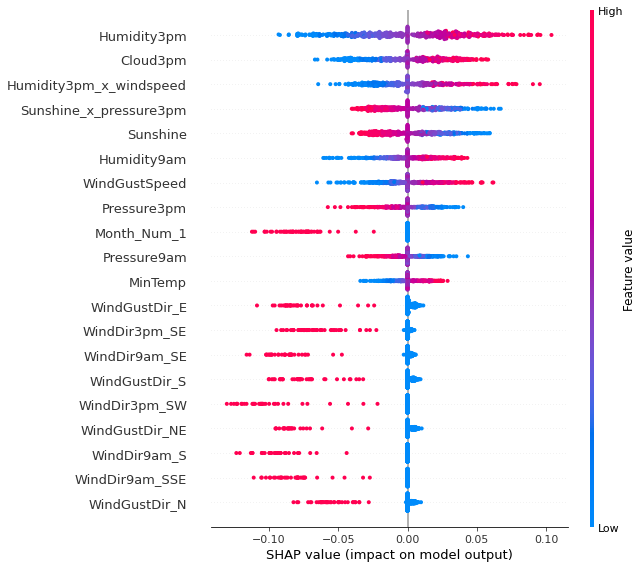

In [105]:
# Make plot with combined shap values
# The training set is too big so let's sample it. We get enough point to draw conclusions
X_train_sample = X_train.sample(500)
shap_values  = explainer.shap_values(X_train_sample)
shap.summary_plot(shap_values, X_train_sample)

As suspected humidity and cloud features are the most important. It is also unsurprising that the features that are the product of important features also have high impact. Interesting Month_Num_1 (January) has a high impact, suggesting much less ran in Australia in this period. This makes sense as this is their summer season but interesting that the model picked up on this.